In [1]:
#from https://www.kaggle.com/inversion/leaderboard-progression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
import seaborn as sns
sns.set()


# ~~~~~~~~~~~~~~~~ Begin configuration ~~~~~~~~~~~~~~~~

# Kaggle admins have to put the file here, but you can run the script
#  locally and use the LB data provided at the bottom of the contest LB
file_name = '../input/lb-twosigma/two-sigma-financial-news-publicleaderboard.csv' 

# Set the range of LB "action" we want to see
min_score = -3
max_score = 6

# Which direction is a better evaluation metric score?
lower_is_better = False

# A reasonable default
num_bins = 100

# ~~~~~~~~~~~~~~~~ End configuration ~~~~~~~~~~~~~~~~


scores = pd.read_csv(file_name, parse_dates=['SubmissionDate'])
print("Scores shape: ",np.shape(scores)," columns:",scores.columns)
# keep the date only
scores['SubmissionDate'] = scores['SubmissionDate'].apply(lambda x: x.date())


Scores shape:  (971, 4)  columns: Index(['TeamId', 'TeamName', 'SubmissionDate', 'Score'], dtype='object')


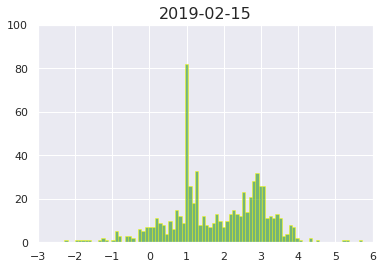

In [2]:
# some kung-fu to figure out the ylim for the last graph
scores_gb = scores.groupby('TeamName')
if lower_is_better:
    scores_final = scores_gb.min()
else:
    scores_final = scores_gb.max()
mask = (scores_final.Score <= max_score) & (scores_final.Score >= min_score)
bins = np.linspace(min_score,max_score, num_bins+1)
ymax = np.histogram(scores_final.loc[mask, 'Score'].values, bins)[0].max()
ymax = int(np.ceil(ymax / 100.0)) * 100 # round up to nearest 100

# We want the best score submitted for team up to and including a specific date,
#  so we need to keep a running list of the cumulative dates
cum_date = []

# Mapping the dates for use in the animation loop
dates_dict = {e:date for e, date in enumerate(scores['SubmissionDate'].unique())}

# Set up the initial historgram
#   see: http://matplotlib.org/examples/animation/histogram.html
n, _ = np.histogram(scores_final.loc[mask, 'Score'].values, bins)
fig, ax = plt.subplots()
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n
nrects = len(left)
nverts = nrects*(1+3+1)
verts = np.zeros((nverts, 2))
codes = np.ones(nverts, int) * path.Path.LINETO
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5,0] = left
verts[0::5,1] = bottom
verts[1::5,0] = left
verts[1::5,1] = top
verts[2::5,0] = right
verts[2::5,1] = top
verts[3::5,0] = right
verts[3::5,1] = bottom
barpath = path.Path(verts, codes)
patch = patches.PathPatch(barpath, facecolor='green', edgecolor='yellow', alpha=0.5)
ax.add_patch(patch)
ax.set_xlim(min_score, max_score)
ax.set_ylim(0, ymax)

def animate(e):

    # Grab all the scrores to date, grouped by Team
    cum_date.append(dates_dict[e])
    lb_gb = scores.loc[scores['SubmissionDate'].isin(cum_date)].groupby('TeamName')

    # Find the best score of each team
    if lower_is_better:
        lb = lb_gb.min()
    else:
        lb = lb_gb.max()

    # Throw out scores outside the defined range
    mask = (lb.Score <= max_score) & (lb.Score >= min_score)
    
    # Calculate the new histogram
    n, _ = np.histogram(lb[mask].Score.values, bins)
    
    # Update the figure
    top = bottom + n
    verts[1::5,1] = top
    verts[2::5,1] = top
    plt.title(dates_dict[e], fontsize=16)
#print(dates_dict)
anim = animation.FuncAnimation(fig, animate, frames=len(dates_dict), blit=False)
anim.save('lb.gif', fps=3, writer='imagemagick')
plt.show()